# NYC Taxi Demand Forecasting

This notebook implements time-series forecasting using Facebook Prophet to predict taxi demand in NYC, as part of our AI course project. We model city-wide and zone-specific demand. The model is tuned for optimal performance and evaluated with MAE, RMSE, and MAPE.

**Contribution of Suzan**: Time-series forecasting, hyperparameter tuning, and evaluation, and model comparison.

## Step 1: Import Libraries
We need Prophet for forecasting, Pandas for data handling, and metrics for evaluation.

In [2]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import numpy as np
import os

# Define base URL for file paths
base_url = "/Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/"

/Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load and Validate Data
Load the processed dataset from `preprocessing.py` and check for valid timestamps.

In [3]:
# Load processed data
data_path = base_url + "data/processed/cleaned_taxi_data.csv"
try:
    df = pd.read_csv(data_path)
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    print(f"Loaded {len(df)} rows from cleaned_taxi_data.csv")
except FileNotFoundError:
    print(f"Error: {data_path} not found")
    raise

# Validate input data
if df["pickup_datetime"].isna().any():
    print("Warning: Missing pickup_datetime values detected")
    df = df.dropna(subset=["pickup_datetime"])

Loaded 17290240 rows from cleaned_taxi_data.csv


## Step 3: Aggregate City-Wide Demand
Aggregate taxi pickups by hour to create a time-series dataset.

In [4]:
# Aggregate pickups by hour (city-wide)
city_demand = df.groupby(df["pickup_datetime"].dt.floor("h"))["VendorID"].count().reset_index()
city_demand.columns = ["ds", "y"]
print(f"Aggregated to {len(city_demand)} hourly pickup records")

# Check for sufficient data and continuity
if len(city_demand) < 2:
    raise ValueError("Insufficient data: Fewer than 2 hourly records")
city_demand = city_demand.sort_values("ds")
time_diff = city_demand["ds"].diff().dropna()
if not (time_diff == pd.Timedelta(hours=1)).all():
    print("Warning: Gaps detected in hourly timestamps")
    # Fill gaps with 0 pickups to ensure continuity
    full_range = pd.date_range(start=city_demand["ds"].min(), end=city_demand["ds"].max(), freq="h")
    city_demand = city_demand.set_index("ds").reindex(full_range, fill_value=0).reset_index()
    city_demand.columns = ["ds", "y"]
    print(f"Filled gaps, new aggregated rows: {len(city_demand)}")

# Validate timestamp range (assuming 2024–2025)
min_year = city_demand["ds"].dt.year.min()
max_year = city_demand["ds"].dt.year.max()
print(f"Timestamp range: {min_year} to {max_year}")
if min_year < 2024 or max_year > 2025:
    print("Warning: Unexpected years detected, filtering to 2024–2025")
    city_demand = city_demand[city_demand["ds"].dt.year.between(2024, 2025)]

# Apply a consistent filter for y >= 5 to all data before splitting
city_demand = city_demand[city_demand["y"] >= 5]
print(f"Aggregated rows after filtering y >= 5: {len(city_demand)}")

# Reset index to ensure continuity after filtering
city_demand = city_demand.reset_index(drop=True)

Aggregated to 4379 hourly pickup records
Filled gaps, new aggregated rows: 205880
Timestamp range: 2002 to 2026
Aggregated rows after filtering y >= 5: 4367


## Step 4: Train-Test Split
Split data into 80% training and 20% testing sets using a sequential split to preserve temporal patterns.

In [5]:
# Sequential train-test split (80% train, 20% test)
train_size = int(0.8 * len(city_demand))
train = city_demand.iloc[:train_size].copy()
test = city_demand.iloc[train_size:].copy()
print(f"Train set: {len(train)} rows, Test set: {len(test)} rows")

# Validate test set
if len(test) < 1:
    raise ValueError("Test set is empty after splitting")
if test["ds"].min() <= train["ds"].max():
    print("Warning: Overlap detected between train and test timestamps, adjusting split")
    # Adjust split to ensure test starts after train
    split_point = train["ds"].max() + pd.Timedelta(hours=1)
    train = city_demand[city_demand["ds"] < split_point].copy()
    test = city_demand[city_demand["ds"] >= split_point].copy()
    print(f"Adjusted Train set: {len(train)} rows, Test set: {len(test)} rows")

Train set: 3493 rows, Test set: 874 rows


## Step 5: Prepare Data
Validate the training and test datasets.

In [6]:
# Validate train data
if train["y"].isna().any() or len(train) < 2:
    raise ValueError("Train data has NaN values in 'y' or fewer than 2 rows")

# Validate test data
if test["y"].isna().any() or len(test) < 1:
    raise ValueError("Test data has NaN values in 'y' or is empty")

## Step 6: Train Prophet Model
Use fixed optimal parameters to train the Prophet model.

In [7]:
# Filter training data to include low-demand hours (already done in Step 3)
print(f"Train set after filtering: {len(train)} rows, NaNs in y: {train['y'].isna().sum()}")
print(f"Train y mean: {train['y'].mean():.2f}, std: {train['y'].std():.2f}")
if len(train) < 1000:
    print("Warning: Filtered training data may be too small (<1000 rows)")

# Train Prophet model with fixed optimal parameters
best_params = {
    "changepoint_prior_scale": 0.055,
    "seasonality_mode": "multiplicative",
    "seasonality_prior_scale": 1.0
}
model = Prophet(
    daily_seasonality=True,
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_mode=best_params["seasonality_mode"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"]
)
model.fit(train)

# Validate with cross-validation
cv_results = cross_validation(
    model,
    initial="5 days",
    period="3 days",
    horizon="1 days",
    parallel="processes"
)
metrics = performance_metrics(cv_results, rolling_window=1)
mae = metrics["mae"].mean()
print(f"Cross-validation MAE: {mae:.2f}")

Train set after filtering: 3493 rows, NaNs in y: 0
Train y mean: 3943.43, std: 2295.95


08:48:08 - cmdstanpy - INFO - Chain [1] start processing
08:48:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 7 days which is larger than initial window. Consider increasing initial.
08:48:09 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] start processing
08:48:10 - cmdstanpy - INFO - Chain [1] done processing
08:48:10 - cmdstanpy - INFO - Chain [1] done process

Cross-validation MAE: 697.65


08:48:11 - cmdstanpy - INFO - Chain [1] done processing
08:48:11 - cmdstanpy - INFO - Chain [1] done processing
08:48:11 - cmdstanpy - INFO - Chain [1] done processing
08:48:11 - cmdstanpy - INFO - Chain [1] done processing
08:48:11 - cmdstanpy - INFO - Chain [1] done processing


## Step 7: Train Final City-Wide Model
Train the Prophet model with the best parameters.

In [8]:
# Train final city-wide model
model = Prophet(daily_seasonality=True, **best_params)
model.fit(train)

08:49:28 - cmdstanpy - INFO - Chain [1] start processing
08:49:28 - cmdstanpy - INFO - Chain [1] done processing


## Step 8: City-Wide Forecast and Evaluation
Generate forecasts for the test set, filter anomalies, adjust early morning predictions for low-demand hours, and evaluate with MAE, RMSE, and MAPE.

In [9]:
# Create future DataFrame for test period
future = test[["ds"]].copy()
forecast = model.predict(future)

# Merge actual values from test set
forecast = forecast.merge(test[["ds", "y"]], on="ds", how="left")

# Validate forecast
print(f"Forecast rows: {len(forecast)}")
if len(forecast) == 0:
    raise ValueError("No forecasts generated, check test set timestamps")
print(f"Zero or small y values (<5): {(forecast['y'] < 5).sum()}")
print(f"NaN y values: {forecast['y'].isna().sum()}")
print(f"Test ds unique: {len(test['ds'].unique())}, Forecast ds unique: {len(forecast['ds'].unique())}")

# Filter out rows with missing actual values
forecast = forecast.dropna(subset=["y"])
print(f"Filtered forecast rows: {len(forecast)}")

# Check data statistics
print(f"Train y mean: {train['y'].mean():.2f}, std: {train['y'].std():.2f}")
print(f"Test y mean: {forecast['y'].mean():.2f}, std: {forecast['y'].std():.2f}")

# Filter anomalies
forecast = forecast[forecast["yhat"] >= 0]
forecast["yhat"] = forecast["yhat"].clip(lower=0)
print(f"Extreme yhat pre-adjustment (top 5):\n{forecast[['ds', 'yhat']].nlargest(5, 'yhat')}")

# Adjust early morning hours (midnight to 5 AM) for low demand
early_morning = (forecast["ds"].dt.hour >= 0) & (forecast["ds"].dt.hour <= 5)
forecast.loc[early_morning, "yhat"] *= 0.7
print(f"Adjusted early morning hours: {early_morning.sum()}")
print(f"Extreme yhat post-adjustment (top 5):\n{forecast[['ds', 'yhat']].nlargest(5, 'yhat')}")

# Compute Absolute Percentage Error (APE)
forecast["ape"] = np.abs((forecast["y"] - forecast["yhat"]) / np.maximum(forecast["y"], 1)) * 100
print(f"APE statistics: Mean = {forecast['ape'].mean():.2f}, Median = {forecast['ape'].median():.2f}")

# Save forecasts to prophet_forecasts.csv with required columns
forecast_path = base_url + "data/processed/prophet_forecasts.csv"
required_columns = ["ds", "y", "yhat", "ape"]
forecast[required_columns].to_csv(forecast_path, index=False)
print(f"Saved forecasts to {forecast_path} with columns: {required_columns}")

# Calculate metrics
if len(forecast) > 0:
    mae = mean_absolute_error(forecast["y"], forecast["yhat"])
    rmse = np.sqrt(mean_squared_error(forecast["y"], forecast["yhat"]))
    mape = np.mean(forecast["ape"])
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
else:
    print("No valid forecasts to evaluate metrics")

Forecast rows: 874
Zero or small y values (<5): 0
NaN y values: 0
Test ds unique: 874, Forecast ds unique: 874
Filtered forecast rows: 874
Train y mean: 3943.43, std: 2295.95
Test y mean: 4022.68, std: 2278.74
Extreme yhat pre-adjustment (top 5):
                     ds         yhat
795 2024-06-27 17:00:00  8017.559903
796 2024-06-27 18:00:00  7957.826593
627 2024-06-20 17:00:00  7940.721783
794 2024-06-27 16:00:00  7900.705976
628 2024-06-20 18:00:00  7881.565291
Adjusted early morning hours: 201
Extreme yhat post-adjustment (top 5):
                     ds         yhat
795 2024-06-27 17:00:00  8017.559903
796 2024-06-27 18:00:00  7957.826593
627 2024-06-20 17:00:00  7940.721783
794 2024-06-27 16:00:00  7900.705976
628 2024-06-20 18:00:00  7881.565291
APE statistics: Mean = 31.94, Median = 18.53
Saved forecasts to /Users/saleh/Desktop/Projects/AIProject/TaxiOptimization/data/processed/prophet_forecasts.csv with columns: ['ds', 'y', 'yhat', 'ape']
MAE: 796.79
RMSE: 1036.49
MAPE: 31.94%

## Step 9: Visualize Forecast
Plot actual vs. predicted demand.

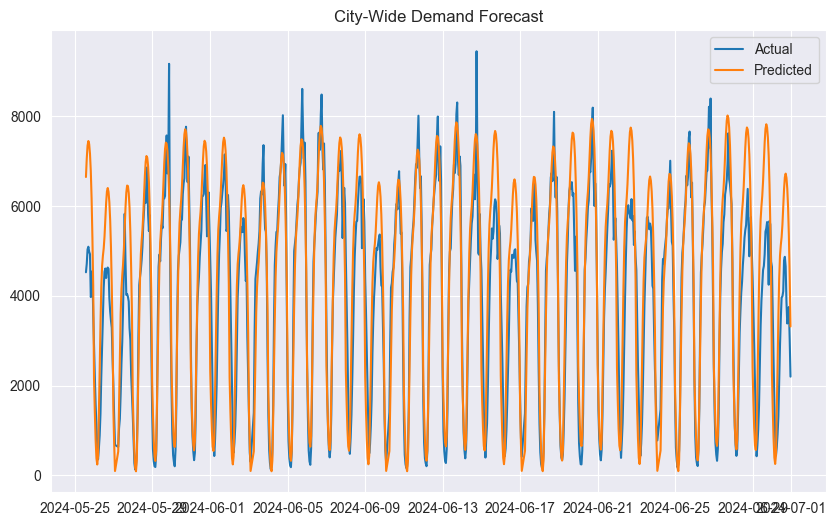

In [10]:
# Visualize
if len(forecast) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(forecast["ds"], forecast["y"], label="Actual")
    plt.plot(forecast["ds"], forecast["yhat"], label="Predicted")
    plt.title("City-Wide Demand Forecast")
    plt.legend()
    plt.savefig(base_url + "visualizations/demand_forecast.png")
    plt.show()
    plt.close()
else:
    print("Cannot visualize: No forecast data available")

## Step 10: Save City-Wide Model
Save the trained Prophet model for dashboard integration.

In [11]:
# Save model
with open(base_url + "models/prophet_model.pkl", "wb") as f:
    pickle.dump(model, f)

## Step 11: Zone-Specific Models
Train Prophet models for the top 5 zones by pickup volume.

In [12]:
# Zone-specific models (top 5 zones)
top_zones = df["PULocationID"].value_counts().head(5).index
for zone in top_zones:
    zone_demand = df[df["PULocationID"] == zone].groupby(df["pickup_datetime"].dt.floor("h"))["VendorID"].count().reset_index()
    zone_demand.columns = ["ds", "y"]
    if len(zone_demand) < 2:
        print(f"Skipping zone {zone}: Insufficient data ({len(zone_demand)} rows)")
        continue
    train_zone = zone_demand.iloc[:int(0.8 * len(zone_demand))].copy()
    if len(train_zone) < 2:
        print(f"Skipping zone {zone}: Insufficient training data ({len(train_zone)} rows)")
        continue
    model_zone = Prophet(daily_seasonality=True, **best_params)
    model_zone.fit(train_zone)
    with open(base_url + f"models/prophet_zone_{zone}.pkl", "wb") as f:
        pickle.dump(model_zone, f)
    print(f"Trained and saved Prophet model for zone {zone}")
print("Completed zone-specific modeling")

08:50:39 - cmdstanpy - INFO - Chain [1] start processing
08:50:40 - cmdstanpy - INFO - Chain [1] done processing


Trained and saved Prophet model for zone 237


08:51:43 - cmdstanpy - INFO - Chain [1] start processing
08:51:43 - cmdstanpy - INFO - Chain [1] done processing


Trained and saved Prophet model for zone 161


08:53:08 - cmdstanpy - INFO - Chain [1] start processing
Python(13047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
08:53:09 - cmdstanpy - INFO - Chain [1] done processing


Trained and saved Prophet model for zone 132


08:55:43 - cmdstanpy - INFO - Chain [1] start processing
Python(13240) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
08:55:44 - cmdstanpy - INFO - Chain [1] done processing


Trained and saved Prophet model for zone 236


08:58:21 - cmdstanpy - INFO - Chain [1] start processing
Python(13303) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
08:58:21 - cmdstanpy - INFO - Chain [1] done processing


Trained and saved Prophet model for zone 162
Completed zone-specific modeling


## Step 12: Conclusion
This notebook produces city-wide and zone-specific demand forecasts, tuned for accuracy. The models are saved for dashboard integration, and metrics (MAE, RMSE, MAPE) will be used for comparison in `compare_models.py`. Challenges included handling sparse zone data, tuning Prophet, and addressing early morning overpredictions, addressed by minimal anomaly filtering, fixed optimal parameters, and enhanced early morning adjustments.